This is an experiment in collecting instagram data to gather insights about London. One inspiration was from http://www.datascopeanalytics.com/blog/instagrams-blind-spot/, but I am also hoping to learn about what people are taking photos of, plus a bit of image analysis (colors of instagram viz comes to mind), and maybe eventually playing with doing some sort of image recognition with neural networks (if I ever get that far 😅)

Anyways, what I've done is to call the media_search api endpoint to scrape photos from London -- instagram only seems to let you call 20 photos for this, so what I've done is to split up greater london into a grid of latlng pairs and hoover up stuff per grid. Obviously new photos are added all the time so to get the most out of it I set up a AWS lambda function that runs every hour to pick up new stuff. 

Obviously there will be duplications but I've imported all the files into a mongoDB with a unique index on the photo id to get unique posts

The lambda and the parser is in nodejs since that's what I know most, but python comes with some handy tools (including scikit learn and notebooks...) so handing over to python for this bit...


In [1]:
import numpy as np
import pandas as pd
import pymongo
from pymongo import MongoClient
client = MongoClient()

In [2]:
from pprint import pprint

In [3]:
from bson.son import SON #needs sorting so...

In [121]:
#for geo parsing
import json
from shapely.geometry import shape, Point, mapping

In [31]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import mplleaflet

In [155]:
import geopandas as gpd
from shapely.ops import cascaded_union

In [6]:
#db setup-- the posts collection is the only one for stashing everything returned from that api endpoint
db = client.instagramLondon
coll = db.posts

In [8]:
#here's what one record looks like
pprint(coll.find_one())

{'_id': ObjectId('57c46f2e4f084b83079167ac'),
 'attribution': None,
 'caption': {'created_time': '1472338156',
             'from': {'full_name': 'Carlos Pinto @ London-Lisbon',
                      'id': '245152137',
                      'profile_picture': 'https://scontent.cdninstagram.com/t51.2885-19/10932399_451400081695046_252473917_a.jpg',
                      'username': 'carlosmpinto10'},
             'id': '17862561217003381',
             'text': 'Category is "west London realness"! Thank you for coming '
                     'and eating all my Portuguese saussages!!'},
 'comments': {'count': 0},
 'created_time': '1472338156',
 'filter': 'Normal',
 'id': '1326391051846276361_245152137',
 'images': {'low_resolution': {'height': 320,
                               'url': 'https://scontent.cdninstagram.com/t51.2885-15/s320x320/e35/14031729_1508980895794743_1117711764_n.jpg?ig_cache_key=MTMyNjM5MTA1MTg0NjI3NjM2MQ%3D%3D.2.l',
                               'width': 320},
      

Some fields of interest here-- 
* tags (array) -- what are people talking about?
* timestamp -- it's stored as a ISODate -- this is done in the parser from 'created_time'
* images -- the url link to, would be really useful for color analysis
* location -- for mapping, obviously 😄

In [9]:
#some basic stats about the collection so far
print('number of records: {}'.format(coll.count()))

number of records: 96048


In [10]:
#what are the top tags?
pipeline = [ 
    {"$unwind": "$tags"}, 
    {"$group": {"_id": "$tags", "count": { "$sum": 1 }}}, 
    {"$sort" : SON({ "count" : -1}) }, 
    {"$limit": 20}]
aggCursor = db.posts.aggregate(pipeline)
toptags = list(aggCursor)
toptags

[{'_id': 'london', 'count': 25723},
 {'_id': 'uk', 'count': 3948},
 {'_id': 'travel', 'count': 3172},
 {'_id': 'love', 'count': 2908},
 {'_id': 'summer', 'count': 2735},
 {'_id': 'londonlife', 'count': 2606},
 {'_id': 'england', 'count': 2320},
 {'_id': 'instagood', 'count': 2318},
 {'_id': 'nottinghillcarnival', 'count': 2271},
 {'_id': 'carnival', 'count': 2092},
 {'_id': 'nottinghill', 'count': 2088},
 {'_id': 'art', 'count': 1967},
 {'_id': 'photooftheday', 'count': 1790},
 {'_id': 'architecture', 'count': 1761},
 {'_id': 'thisislondon', 'count': 1663},
 {'_id': 'photography', 'count': 1657},
 {'_id': 'fashion', 'count': 1632},
 {'_id': 'bankholiday', 'count': 1631},
 {'_id': 'picoftheday', 'count': 1572},
 {'_id': 'instadaily', 'count': 1499}]

unsurprisingly, london comes top as a tag...
However, there are some that I expect to be more 'seasonal'. e.g nottinghillcarnival (27-28 Aug 2016), bankholiday (29-8-2016)
It would also be interesting to see which locations have a higher density of tags e.g. west end with 'theatre' maybe? Or 'bigben' around Westminster?

In [11]:
#min date:
list(db.posts.find().sort("timestamp", pymongo.ASCENDING).limit(1))[0]['timestamp']

datetime.datetime(2016, 8, 19, 15, 42, 48)

In [12]:
#max date so far:
list(db.posts.find().sort("timestamp", pymongo.DESCENDING).limit(1))[0]['timestamp']

datetime.datetime(2016, 8, 31, 21, 54, 59)

In [13]:
#similar to tags, lets see who the top users are:
pipeline = [
    {"$group": {"_id": {"userid" :"$user.id", "name" : "$user.full_name"}, "count": { "$sum": 1 }}}, 
    {"$sort" : SON({ "count" : -1}) }, 
    {"$limit": 20}]
aggCursor = db.posts.aggregate(pipeline)
topUsers = list(aggCursor)
topUsers

[{'_id': {'name': '💕11/03/2016💕', 'userid': '1800822004'}, 'count': 96},
 {'_id': {'name': 'JUNJUN∵ゞ(´ε`⚫️)', 'userid': '1235345995'}, 'count': 57},
 {'_id': {'name': 'Nav Sandhu', 'userid': '2284422920'}, 'count': 53},
 {'_id': {'name': 'Irina Richie London', 'userid': '1274480976'}, 'count': 46},
 {'_id': {'name': 'Will Hammond', 'userid': '1562996357'}, 'count': 42},
 {'_id': {'name': 'Wim Deman', 'userid': '3571195078'}, 'count': 38},
 {'_id': {'name': '', 'userid': '355544734'}, 'count': 35},
 {'_id': {'name': 'Şirvan Uslu', 'userid': '1688297718'}, 'count': 32},
 {'_id': {'name': 'Ellz M', 'userid': '241533014'}, 'count': 31},
 {'_id': {'name': 'Nico', 'userid': '721280469'}, 'count': 31},
 {'_id': {'name': 'вrian 😷💉', 'userid': '7115543'}, 'count': 30},
 {'_id': {'name': '', 'userid': '2234850097'}, 'count': 30},
 {'_id': {'name': 'Jang', 'userid': '3261681681'}, 'count': 30},
 {'_id': {'name': 'Isabel Levin', 'userid': '1496882725'}, 'count': 28},
 {'_id': {'name': 'Silvia Vetr

In [14]:
#hmm, weirdly some users don't seem to have a name?? Lets check:
coll.find_one({"user.id": '3665940198'})

{'_id': ObjectId('57c46f434f084b830791ead5'),
 'attribution': None,
 'caption': {'created_time': '1472347035',
  'from': {'full_name': '',
   'id': '3665940198',
   'profile_picture': 'https://scontent.cdninstagram.com/t51.2885-19/s150x150/14052574_154788661623879_146262989_a.jpg',
   'username': '30_30_europe'},
  'id': '17851887115098564',
  'text': '.\n예약해 둔 스카이가든 가기 전에 들른 버로우마켓. 식료품 전문이라 들어가는 순간 맛있는 음식들이 천지삐까리! -\n\n#유럽여행 #런던여행 #버로우마켓 #boroughmarket'},
 'comments': {'count': 0},
 'created_time': '1472347035',
 'filter': 'Normal',
 'id': '1326465530261260760_3665940198',
 'images': {'low_resolution': {'height': 320,
   'url': 'https://scontent.cdninstagram.com/t51.2885-15/s320x320/e35/14031706_1254496294594574_1241856600_n.jpg?ig_cache_key=MTMyNjQ2NTUzMDI2MTI2MDc2MA%3D%3D.2.l',
   'width': 320},
  'standard_resolution': {'height': 640,
   'url': 'https://scontent.cdninstagram.com/t51.2885-15/s640x640/sh0.08/e35/14031706_1254496294594574_1241856600_n.jpg?ig_cache_key=MTMyNjQ2NTUzMDI2

In [15]:
#aha-- I should have used the 'username' field rather than the full_name-- try again
pipeline = [
    {"$group": {"_id": {"userid" :"$user.id", "name" : "$user.username", "displayname":  "$user.full_name"}, "count": { "$sum": 1 }}}, 
    {"$sort" : SON({ "count" : -1}) }, 
    {"$limit": 20}]
aggCursor = db.posts.aggregate(pipeline)
topUsers = list(aggCursor)
topUsers

[{'_id': {'displayname': '💕11/03/2016💕',
   'name': 'iwantsel2know',
   'userid': '1800822004'},
  'count': 96},
 {'_id': {'displayname': 'JUNJUN∵ゞ(´ε`⚫️)',
   'name': 'junejunejunesay',
   'userid': '1235345995'},
  'count': 57},
 {'_id': {'displayname': 'Nav Sandhu',
   'name': 'nav_77_sandhu',
   'userid': '2284422920'},
  'count': 53},
 {'_id': {'displayname': 'Irina Richie London',
   'name': 'angelgol888',
   'userid': '1274480976'},
  'count': 46},
 {'_id': {'displayname': 'Will Hammond',
   'name': 'the_face50',
   'userid': '1562996357'},
  'count': 42},
 {'_id': {'displayname': 'Wim Deman',
   'name': 'wimbaland',
   'userid': '3571195078'},
  'count': 38},
 {'_id': {'displayname': '', 'name': 'me_eunk', 'userid': '355544734'},
  'count': 35},
 {'_id': {'displayname': 'Şirvan Uslu',
   'name': 'sirvanuslu',
   'userid': '1688297718'},
  'count': 32},
 {'_id': {'displayname': 'Ellz M', 'name': 'rawdoku', 'userid': '241533014'},
  'count': 31},
 {'_id': {'displayname': 'Nico', 

locations-- now here come the interesting part. If I use the census output areas polygons the location has to be mapped to each polygon... and with that many entries...?

interstingly, each location has an id, so a more efficient way may be to check for unique ids and see what they are like first

In [8]:
distinctLocations = db.posts.distinct('location.id')
len(distinctLocations)

12473

still a lot but quite a bit smaller than the number of entries...
tools wise-- off the top of my head, explore turf.js. Also ogr and python has some geo tools too I think...

london datastore has a stash of gis files relating to the OA in london-- can use these to get the right polygons
using a combination of https://gist.github.com/benbalter/5858851 and https://github.com/mapbox/geojson-merge, I managed to get a geojson file with all the oa polygons in it. Now to figure out how to assign points to the polygons... there's shapely / basemap in python that may do the job...

In [17]:
with open('OA_2011_BGC_london.json', 'r') as f:
    geojsonLondon = json.load(f)

In [18]:
#as per normal for geojson, the fields are 'features' and 'type'
geojsonLondon.keys()

dict_keys(['type', 'features'])

In [19]:
#inspecting what one of these areas look like-- the OA11CD is the smallest resolution one and is the one I would need...
geojsonLondon['features'][0]

{'geometry': {'coordinates': [[[0.123626833290036, 51.54779654745277],
    [0.12335574483778, 51.547152580307085],
    [0.124461441009959, 51.54699949469959],
    [0.124735067322051, 51.546485385256254],
    [0.124260323507369, 51.546072464300984],
    [0.12317806894117, 51.54672764976483],
    [0.122411920235362, 51.54611423142708],
    [0.120869568613431, 51.54600154289857],
    [0.120582018615427, 51.546843636735105],
    [0.121599655706706, 51.546774408971245],
    [0.121919852670241, 51.54739286050572],
    [0.122225107444166, 51.54802445915372],
    [0.123626833290036, 51.54779654745277]]],
  'type': 'Polygon'},
 'properties': {'AVHHOLDSZ': 2.4,
  'COMESTRES': 0,
  'HHOLDRES': 291,
  'HHOLDS': 123,
  'LAD11CD': 'E09000002',
  'LAD11NM': 'Barking and Dagenham',
  'LSOA11CD': 'E01000074',
  'LSOA11NM': 'Barking and Dagenham 012C',
  'MSOA11CD': 'E02000013',
  'MSOA11NM': 'Barking and Dagenham 012',
  'OA11CD': 'E00000371',
  'POPDEN': 85.8,
  'RGN11CD': 'E12000007',
  'RGN11NM': 'L

In [7]:
#one of the points:
locations = db.posts.aggregate([{"$group": { "_id": {"locationid": "$location.id","lat": "$location.latitude", "lng": "$location.longitude" } , "count": { "$sum": 1 }  }}]);

In [8]:
locations = list(locations)

In [21]:
locations[1000]

{'_id': {'lat': 28.950551311129,
  'lng': -13.60872499554,
  'locationid': 257558453},
 'count': 1}

In [35]:
#a quick test of the point finding routine with the first point in the locations list
testPoint = Point(locations[0]['_id']['lng'], locations[0]['_id']['lat'])  #remember geojson is in [lng, lat]!!
for feature in geojsonLondon['features']:
    polygon = shape(feature['geometry'])
    if polygon.contains(testPoint):
        print( 'Found containing polygon:')
        print(feature['properties']['OA11CD'])

Found containing polygon:
E00013442


In [36]:
#function for finding the OA11cd code for each point...
def findContainingPolygon(lng, lat):
    testPoint = Point(lng, lat)
    for feature in geojsonLondon['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(testPoint):
            return (feature['properties']['OA11CD'])
    return ""

In [37]:
#testing it again on point 1
findContainingPolygon(locations[0]['_id']['lng'], locations[0]['_id']['lat'])

'E00013442'

In [10]:
#lets try plotting a dot density map with Basemap first before going into full scale geospatial analysis...
map = Basemap(urcrnrlat=51.531074,     # top
              urcrnrlon=-0.069970,   # bottom
              llcrnrlat=51.481157,     # left
              llcrnrlon=-0.219215,   # right
              epsg=3857)
# map = Basemap(urcrnrlat=37.821981,     # top
#               urcrnrlon=-122.343189,   # bottom
#               llcrnrlat=37.697940,     # left
#               llcrnrlon=-122.574915,   # right
#               epsg=3857)


In [11]:
width = 100
height = 100

fig = plt.gcf()
fig.set_size_inches(width, height);


http://server.arcgisonline.com/arcgis/rest/services/Canvas/World_Light_Gray_Base/MapServer/export?bbox=-24402.902174247465,6706850.231189484,-7789.024770805353,6715777.7024310045&bboxSR=3857&imageSR=3857&size=9600,5158&dpi=96&format=png32&f=image


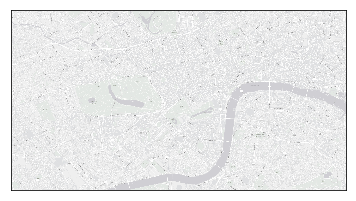

In [12]:
dpi = 96
xpixels = dpi * width
map.arcgisimage(server='http://server.arcgisonline.com/arcgis', service='Canvas/World_Light_Gray_Base', xpixels=xpixels, dpi=96, verbose=True)
# map.arcgisimage(service='Canvas/World_Light_Gray_Base', xpixels=xpixels)
plt.show();

In [13]:
lngPoints = [x['_id']['lng'] for x in locations]
latPoints = [x['_id']['lat'] for x in locations]
pointCount = [x['count'] for x in locations]

In [24]:
x, y = map(lngPoints, latPoints)

-0.10764048

In [39]:
#hmm, this doesn't seem to work -- no scatter plot??
# plt.gcf().set_size_inches(width, height)
# # map.arcgisimage(server='http://server.arcgisonline.com/arcgis', service='Canvas/World_Light_Gray_Base', xpixels=xpixels, dpi=96, verbose=True)
# map.scatter(lngPoints[0], latPoints[0], c='r', alpha=0.9, marker='s', s=20, linewidths=0, latlon= True)
# plt.show()

plt.scatter(lngPoints[0:200], latPoints[0:200], c='r', alpha=0.9, marker='s', s=20, linewidths=0)
mplleaflet.display(tiles=mplleaflet.maptiles.osm)


In [49]:
#I've only plotted 200 or so data points-- otherwise the browser isn't too happy... 
#basically is planning to do some clustering anyway and geopandas may be a good tool to use
londonGeoDF = gpd.read_file('OA_2011_BGC_london.json')

In [50]:
londonGeoDF.head()

,AVHHOLDSZ,COMESTRES,HHOLDRES,HHOLDS,LAD11CD,LAD11NM,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,OA11CD,POPDEN,RGN11CD,RGN11NM,USUALRES,WD11CD_BF,WD11NM_BF,geometry
0,2.4,0,291,123,E09000002,Barking and Dagenham,E01000074,Barking and Dagenham 012C,E02000013,Barking and Dagenham 012,E00000371,85.8,E12000007,London,291,E05000036,Mayesbrook,"POLYGON ((0.123626833290036 51.54779654745277,..."
1,2.6,0,323,124,E09000002,Barking and Dagenham,E01000073,Barking and Dagenham 012B,E02000013,Barking and Dagenham 012,E00000370,88.3,E12000007,London,323,E05000036,Mayesbrook,"POLYGON ((0.114355116990793 51.54695588394154,..."
2,2.4,0,329,135,E09000002,Barking and Dagenham,E01000074,Barking and Dagenham 012C,E02000013,Barking and Dagenham 012,E00000372,116.7,E12000007,London,329,E05000036,Mayesbrook,"POLYGON ((0.120582018615427 51.5468436367351, ..."
3,2.7,0,291,107,E09000002,Barking and Dagenham,E01000074,Barking and Dagenham 012C,E02000013,Barking and Dagenham 012,E00000375,113.7,E12000007,London,291,E05000036,Mayesbrook,"POLYGON ((0.118107462304139 51.54678149170271,..."
4,2.4,0,275,113,E09000002,Barking and Dagenham,E01000074,Barking and Dagenham 012C,E02000013,Barking and Dagenham 012,E00000377,97.5,E12000007,London,275,E05000036,Mayesbrook,"POLYGON ((0.120783314586704 51.54480800628029,..."


In [52]:
points = [Point(x['_id']['lng'], x['_id']['lat']) for x in locations]

In [163]:
locationsDF = pd.DataFrame({'geometry': points})
locationsDF['locationCount'] = pointCount
locationsDF['locationID'] = [x['_id']['locationid'] for x in locations]
locationsDF = gpd.GeoDataFrame(locationsDF)

also parse out the lat lngs for non shapely ops

In [166]:
locationsDF['lng'] = locationsDF['geometry'].map(lambda x: x.xy[0][0])
locationsDF['lat'] = locationsDF['geometry'].map(lambda x: x.xy[1][0])
locationsDF.head()

,geometry,locationCount,locationID,lng,lat
0,POINT (-0.10764048 51.52873915172),1,8057457,-0.107640,51.528739
1,POINT (-0.12616008173597 51.528634145464),1,228357613,-0.126160,51.528634
2,POINT (-0.1536313119604 51.520704607159),1,374766030,-0.153631,51.520705
3,POINT (-0.17420751 51.52767352),1,934592479,-0.174208,51.527674
4,POINT (-0.08711439999999999 51.5233125),1,252296618,-0.087114,51.523313


In [167]:
#save it to csv for plotting
locationsDF.to_csv('instagram-london-locations.csv')

In [67]:
#now trim the londonGeo stuff to may it smaller... hopefully this will make any op faster
londonDFSubset = londonGeoDF.ix[:,['OA11CD', 'POPDEN', 'WD11NM_BF', 'geometry']]

In [69]:
londonDFSubset.head()

,OA11CD,POPDEN,WD11NM_BF,geometry
0,E00000371,85.8,Mayesbrook,"POLYGON ((0.123626833290036 51.54779654745277,..."
1,E00000370,88.3,Mayesbrook,"POLYGON ((0.114355116990793 51.54695588394154,..."
2,E00000372,116.7,Mayesbrook,"POLYGON ((0.120582018615427 51.5468436367351, ..."
3,E00000375,113.7,Mayesbrook,"POLYGON ((0.118107462304139 51.54678149170271,..."
4,E00000377,97.5,Mayesbrook,"POLYGON ((0.120783314586704 51.54480800628029,..."


In [75]:
#let's try doing a spatial join
gpd.sjoin(locationsDF, londonDFSubset, how="inner", op='contains')

,geometry,count,index_right,OA11CD,POPDEN,WD11NM_BF


In [76]:
print(locationsDF.crs)
print(londonDFSubset.crs)

None
{'init': 'epsg:4326'}


In [94]:
#ah, I guess I need to set the crs of the points...
locationsDF.crs = londonDFSubset.crs

In [95]:
mergedDF = gpd.sjoin(locationsDF, londonDFSubset, how="left", op='within')

In [96]:
mergedDF.head()

,geometry,locationCount,index_right,OA11CD,POPDEN,WD11NM_BF
0,POINT (-0.10764048 51.52873915172),1,14185,E00013556,143.3,Clerkenwell
1,POINT (-0.12616008173597 51.528634145464),1,4171,E00004666,109.2,King's Cross
2,POINT (-0.1536313119604 51.520704607159),1,24347,E00023823,242.9,Marylebone High Street
3,POINT (-0.17420751 51.52767352),1,24799,E00023907,531.3,Regent's Park
4,POINT (-0.08711439999999999 51.5233125),1,14124,E00174772,30.4,Bunhill


In [97]:
#now basically I need to count how many points there are in each OA11CD
grouped = mergedDF.groupby('OA11CD')

In [98]:
grouped.first()

,geometry,locationCount,index_right,POPDEN,WD11NM_BF
OA11CD,,,,,
E00000001,POINT (-0.095 51.5202),19,4938,289.6,Aldersgate
E00000003,POINT (-0.09672 51.5198593),3,4940,595.2,Aldersgate
E00000007,POINT (-0.09661526500000001 51.51537183),1,4941,16.7,Aldersgate
E00000013,POINT (-0.09705 51.52129),4,4932,216.0,Cripplegate
E00000014,POINT (-0.096709888094608 51.522315893533),1,4934,223.2,Cripplegate
E00000017,POINT (-0.09226918141401499 51.520964173293),3,4937,171.6,Cripplegate
E00000018,POINT (-0.0929123 51.5198891),1,4930,44.0,Cripplegate
E00000019,POINT (-0.091482391601983 51.519592926109),1,4931,113.0,Cripplegate
E00000021,POINT (-0.09379999999999999 51.5175),1,4945,20.4,Cripplegate


In [107]:
#not completely what I'm looking for as I need to sum the location counts
groupedDF = mergedDF.groupby('OA11CD').agg({'locationCount': np.sum})
groupedDF = groupedDF.reset_index()

In [108]:
#let's check that it's making sense
groupedDF.head()

,OA11CD,locationCount
0,E00000001,19
1,E00000003,3
2,E00000007,151
3,E00000013,5
4,E00000014,1


In [161]:
grouped = grouped.

AttributeError: Cannot access callable attribute 'reset_index' of 'DataFrameGroupBy' objects, try using the 'apply' method

In [109]:
groupedDF.describe()

,locationCount
count,1601.000000
mean,57.988757
std,209.029301
min,1.000000
25%,2.000000
50%,6.000000
75%,24.000000
max,3174.000000


In [110]:
#looks like some places really do have a LOT more entries than others
#to plot these places on a map, I'll need to get the centroids of each of the regions, then join that geodataframe on the 
#oa11cd attr, and convert back to geojson or shp
#first, check for nans in the groupDF
groupedDF.isnull().values.any()

False

In [138]:
#okay, that should be fine
londonDFSubsetWithCounts = londonDFSubset.merge(groupedDF, on='OA11CD')

In [139]:
londonDFSubsetWithCounts.head()

,OA11CD,POPDEN,WD11NM_BF,geometry,locationCount
0,E00000778,101.0,Coppetts,POLYGON ((-0.153213197972662 51.61303645129745...,1
1,E00002822,162.5,Queens Park,"POLYGON ((-0.215953527081872 51.5293857655481,...",115
2,E00174683,50.3,Wembley Central,"POLYGON ((-0.29145951479525 51.55452598295775,...",3
3,E00004664,265.2,King's Cross,POLYGON ((-0.119252170450243 51.52836784615769...,11
4,E00004666,109.2,King's Cross,POLYGON ((-0.125740268045234 51.52862873785833...,23


In [140]:
londonDFSubsetWithCounts['locationCentroid'] = londonDFSubsetWithCounts['geometry'].centroid

In [141]:
londonDFSubsetWithCounts.head()

,OA11CD,POPDEN,WD11NM_BF,geometry,locationCount,locationCentroid
0,E00000778,101.0,Coppetts,POLYGON ((-0.153213197972662 51.61303645129745...,1,POINT (-0.1530977609392838 51.61353175239727)
1,E00002822,162.5,Queens Park,"POLYGON ((-0.215953527081872 51.5293857655481,...",115,POINT (-0.2174405469537799 51.52902708041863)
2,E00174683,50.3,Wembley Central,"POLYGON ((-0.29145951479525 51.55452598295775,...",3,POINT (-0.2944805887194804 51.5546238433616)
3,E00004664,265.2,King's Cross,POLYGON ((-0.119252170450243 51.52836784615769...,11,POINT (-0.1179907104097869 51.52856727705533)
4,E00004666,109.2,King's Cross,POLYGON ((-0.125740268045234 51.52862873785833...,23,POINT (-0.1281102910598841 51.52775177682784)


In [122]:
#however, to write to json we have to convert the shapely bits back to geojson
mapping(londonDFSubsetWithCounts.iloc[0]['locationCentroid'])

{'coordinates': (-0.15309776093928382, 51.61353175239727), 'type': 'Point'}

In [126]:
londonDFSubsetWithCountsGeojson = londonDFSubsetWithCounts.copy()
londonDFSubsetWithCountsGeojson['geometry'] = \
    londonDFSubsetWithCountsGeojson['geometry'].apply(lambda x: mapping(x))
londonDFSubsetWithCountsGeojson['locationCentroid'] = \
    londonDFSubsetWithCountsGeojson['locationCentroid'].apply(lambda x: mapping(x))

In [127]:
londonDFSubsetWithCountsGeojson.head()

,OA11CD,POPDEN,WD11NM_BF,geometry,locationCount,locationCentroid,geometryGeojson
0,E00000778,101.0,Coppetts,"{'type': 'Polygon', 'coordinates': (((-0.15321...",1,"{'type': 'Point', 'coordinates': (-0.153097760...","{'type': 'Polygon', 'coordinates': (((-0.15321..."
1,E00002822,162.5,Queens Park,"{'type': 'Polygon', 'coordinates': (((-0.21595...",115,"{'type': 'Point', 'coordinates': (-0.217440546...","{'type': 'Polygon', 'coordinates': (((-0.21595..."
2,E00174683,50.3,Wembley Central,"{'type': 'Polygon', 'coordinates': (((-0.29145...",3,"{'type': 'Point', 'coordinates': (-0.294480588...","{'type': 'Polygon', 'coordinates': (((-0.29145..."
3,E00004664,265.2,King's Cross,"{'type': 'Polygon', 'coordinates': (((-0.11925...",11,"{'type': 'Point', 'coordinates': (-0.117990710...","{'type': 'Polygon', 'coordinates': (((-0.11925..."
4,E00004666,109.2,King's Cross,"{'type': 'Polygon', 'coordinates': (((-0.12574...",23,"{'type': 'Point', 'coordinates': (-0.128110291...","{'type': 'Polygon', 'coordinates': (((-0.12574..."


In [135]:
#there's still some issues figuring out how to write a geopandas df to geojson... try to write the count values to 
#csv for now
londonDFSubsetWithCounts.ix[:, ['OA11CD', 'locationCount']].to_csv('instagram-london-counts.csv')

In [130]:
type(londonDFSubsetWithCounts['geometry'])

geopandas.geoseries.GeoSeries

In [152]:
londonDFSubsetWithCounts['lng'] = londonDFSubsetWithCounts['locationCentroid'].map(lambda x: x.xy[0][0])
londonDFSubsetWithCounts['lat'] = londonDFSubsetWithCounts['locationCentroid'].map(lambda x: x.xy[1][0])

In [153]:
londonDFSubsetWithCounts.head()

,OA11CD,POPDEN,WD11NM_BF,geometry,locationCount,locationCentroid,lng,lat
0,E00000778,101.0,Coppetts,POLYGON ((-0.153213197972662 51.61303645129745...,1,POINT (-0.1530977609392838 51.61353175239727),-0.153098,51.613532
1,E00002822,162.5,Queens Park,"POLYGON ((-0.215953527081872 51.5293857655481,...",115,POINT (-0.2174405469537799 51.52902708041863),-0.217441,51.529027
2,E00174683,50.3,Wembley Central,"POLYGON ((-0.29145951479525 51.55452598295775,...",3,POINT (-0.2944805887194804 51.5546238433616),-0.294481,51.554624
3,E00004664,265.2,King's Cross,POLYGON ((-0.119252170450243 51.52836784615769...,11,POINT (-0.1179907104097869 51.52856727705533),-0.117991,51.528567
4,E00004666,109.2,King's Cross,POLYGON ((-0.125740268045234 51.52862873785833...,23,POINT (-0.1281102910598841 51.52775177682784),-0.128110,51.527752


In [154]:
#write the results of the counts and the centroids of these points to csv
londonDFSubsetWithCounts.ix[:, ['OA11CD', 'locationCount', 'lng', 'lat']].to_csv('instagram-london-counts.csv')

it would also be useful to merge the polygons of london into one for easier plotting. let's try with `cascaded_union` in shapely

In [158]:
mergedPolygonLondon = cascaded_union(londonDFSubsetWithCounts['geometry'].tolist())

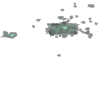

In [159]:
mergedPolygonLondon

hmm, that don't look too promising at all. Possbily may need to resort to ogr2ogr?
Also, think about it now, may need to normalise the counts accord to population/population. but perhaps leave that for now

In [160]:
len(londonDFSubset)

25053

In [ ]:
#after plotting the points on a map, I realised that the code used for pulling data from instagram has an error in 
# the lat lng ranges 